<img src="https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration/blob/master/static/sdulogo-uk-sort-feb2019.png?raw=true" width=300> 
Made in a assignments in the course Project in Advanced Robotics at The University of Southern Denmark

# This Notebook will show a complete pipeline of the flexiblecc module

## Introduktion

##### Camera calibration is an important part of vision algorithms. Stereo vision, pose-estimation, object detection, tracking etc., all rely on accurate camera models to properly depict the world around them. 

##### Most algorithms introduce their own error, but the error inherent in the camera model persists through subsequent algorithms and will often bias the results. Most current vision programs use some version of parametric camera models, usually a refined version of the basic pinhole camera, which makes certain assumptions about the cameras physical properties and about the distribution of distortion. 

##### If the assumptions about the camera model can be removed and it can be modelled in a more specific and quantifiable way instead, it would increase the accuracy of vision algorithms and reduce bias in the results. 

##### This is the motivation for the generic camera model, which models incoming light in rays on a pr. pixel base, giving many more degrees of freedom and thereby a model more closely resembling the actual camera. 

##### Throughout this notebook the terms backward projection and forward projection will be used. Backward projection is the projection of a 2D point to a 3D ray, both the generic and parametric models are backward models, meaning they project a 2D point to a 3D ray. However to calculate ones residuals in pixel values in the image plane, it is necessary to perform forward projection, which means going from a 3D ray to a 2D point. This is simple when using the parametric model, but it causes an optimization problem, when using a generic model. This is explained later in the notebook.



## TODO:
- Skriv kort om det med forward og backward (J)

## Import our module flexiblecc and get the calibration dataset
##### If it is installt we can import else install it with pip 

In [1]:
import os

In [2]:
try:
    import flexiblecc as fcc
except ImportError as e:
    !pip install flexiblecc
    import flexiblecc as fcc

##### Now let's get the dataset if it is not allready pressent 

In [3]:
data_set = "CalImgs/ChArUco - Sorted/Samsung Galaxy S10 Plus/WideAngle/Fold_1"

In [4]:
if not os.path.exists("../CalImgs/"):
    if not os.path.exists("Flexible-Camera-Calibration/CalImgs"):
        !git clone https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration 
    datasetpath = "Flexible-Camera-Calibration/"+data_set+"/*.jpg"
else:
    datasetpath = "../"+data_set+"/*.jpg"

##### Next we can import a copuel of package we will need

In [5]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from prettytable import PrettyTable
from IPython.display import Video
from IPython.core.display import display, HTML

# Image data

##### To test different calibration methods, it is necessary to have a dataset to calibrate on. The classic approach to calibration uses many images of a checkerboards with known features and distance, which can be used to calculate camera parameters. 

##### For this project the dataset has been constructed using a charuco board, which is a more complex version of a standard checkerboard with unique symbols in each square. 
##### The images are taken with the wide angle mode on a Samsung Galaxy S10P, both because it was convenient, but also because we want a model of a cheap camera not necessarily under the best conditions, so we can get significant distortion to test the different models on. There is a total of 30 images taken at different angles in the dataset used in this notebook.  

##### Normal chessboard calibration for the parametric model is also available and the generic model can be used with this too.



##### Let's first get all the image files

In [6]:
image_files = glob.glob(datasetpath)

##### Then we can load them with opencv and convert them to grayscale for the parametric camera calibration 

In [7]:
color_images = [cv2.imread(f) for f in tqdm(image_files)]
gayscale_images = [cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY) for c_img in tqdm(color_images)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 461.44it/s]


In [8]:
image_shape = color_images[0].shape[:2]

##### Let's see the images from the dataset

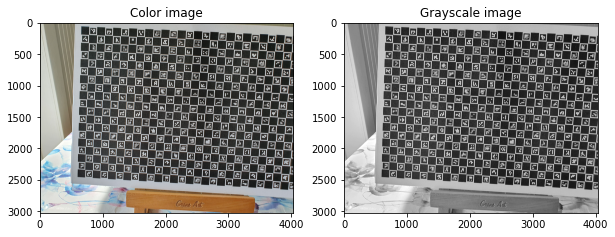

In [9]:
idx = 0

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(cv2.cvtColor(color_images[idx], cv2.COLOR_BGR2RGB))
plt.title("Color image")
plt.subplot(122)
plt.imshow(gayscale_images[idx], cmap="gray")
plt.title("Grayscale image")
plt.show()

##### The dataset contains 30 charuco board calibration images

# Parametric camera calibration

In [10]:
import flexiblecc.Parametric as parcc

##### To have a comparison to the new generic model a parametric calibration using openCV is performed. The calibration uses the charuco board as a known 3D object and correlates it with the images of the board to find the camera matrix and distortion coefficients that accurately models the camera. The distortion is represented as radial distortion, tangential distortion and thin-prism distortion, which have a total of 14 coefficients. 
##### To increase accuracy of the model many images are used with the board in different positions relative to the camera, and the calibration becomes an optimization problem for one model and multiple images. 
##### The remaining error for the camera model after optimization is projected to the image plane <strong>(2D error right?)</strong> and a RMS residual can be calculated, which gives an error in pixel units. 

##### To use the charuco board a set of parameters are neede to define the borad's layout. 

- squaresX: The number of squares in the x axis 
- squaresY: The number of squares in the y axis 
- squareLength: The length of a square in meters 
- markerLength: The length of a marker in meters 
- dictionary: dictionary of markers indicating the type of markers. Can normally be found with cv2.aruco.getPredefinedDictionary

In [11]:
squaresX = 28 
squaresY = 19 
squareLength = 0.01 
markerLength = 0.0075 
dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_1000)

##### Lert's do the calibration for both 5 and 14 distorsion parameters
- 4 + 5 parameters: intrinsic parameters (4), radial distortion (3) and tangential distortion (2)
- 4 + 14 parameters: intrinsic parameters (4), radial distortion (3), tangential distortion (2), rational model (3), prism model (4) and tilted sensor model (2)

In [16]:
calibrate_retval_5dp, cameraMatrix_5dp, distCoeffs_5dp, rvecs_5dp, tvecs_5dp, stdDeviationsIntrinsics_5dp, stdDeviationsExtrinsics_5dp, \
    perViewErrors_5dp, charucoCorners_all_5dp, charucoIds_all_5dp, markerCorners_all_5dp, armarkerIds_all_5dp, obj_points_all_5dp, _ = parcc.calibrate_camera_charuco(gayscale_images, squaresX, squaresY,
                                                                                                                                                  squareLength, markerLength, dictionary, flags=0, verbose=0)

calibrate_retval_14dp, cameraMatrix_14dp, distCoeffs_14dp, rvecs_14dp, tvecs_14dp, stdDeviationsIntrinsics_14dp, stdDeviationsExtrinsics_14dp, \
    perViewErrors_14dp, charucoCorners_all_14dp, charucoIds_all_14dp, markerCorners_all_14dp, armarkerIds_all_14dp, obj_points_all_14dp, board = parcc.calibrate_camera_charuco(gayscale_images, squaresX, squaresY,
                                                                                                                                                  squareLength, markerLength, dictionary, verbose=1)

  0%|                                                                                                                                                                                                                                         | 0/30 [00:00<?, ?image/s]

Finding charuco features


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:05<00:00,  5.79image/s]


Doing camera calibrate
Calibration done


## First let'sa look at where the charuco borads have been in relation to the camera

##### To plot where the boards where we can use the object points with the translation and rotation found under the calibration

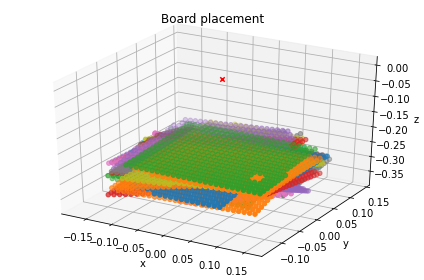

In [17]:
fcc.Metrics.rtvecs_illustration.draw_rtvecs(rvecs_14dp, tvecs_14dp, obj_points_all_14dp)
plt.title("Board placement")
plt.tight_layout()
plt.show()

## Let's look at the distorisen the parametric model has deskribet in the camera

##### First we define a function there kan givein som points return the undistoret points

In [18]:
def undistort(points):
    return cv2.undistortPoints(points, cameraMatrix_14dp, distCoeffs_14dp, P=cameraMatrix_14dp).reshape(-1, 2)

##### Then we can give the function to plot_distort to create a distorisin plot

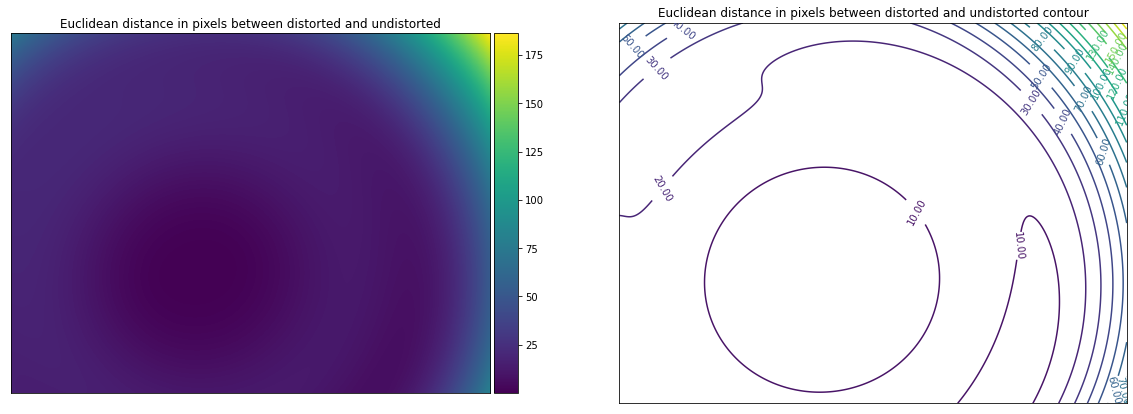

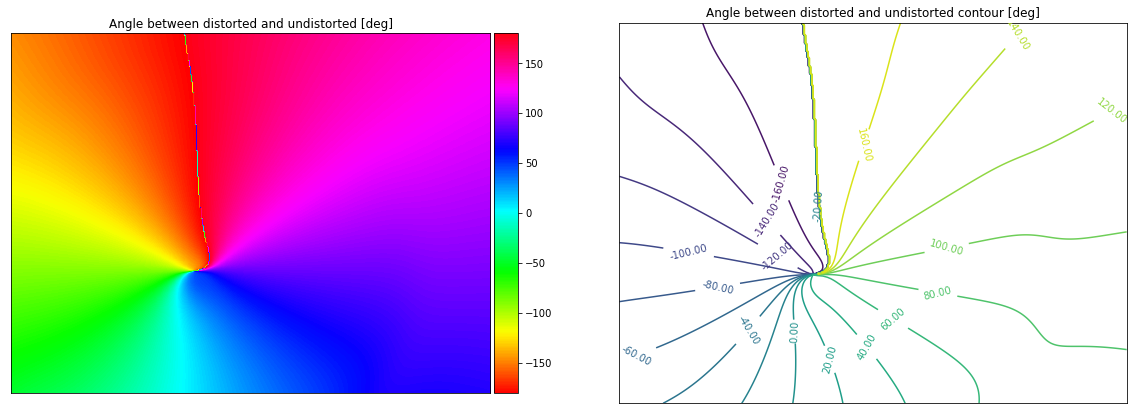

In [19]:
fcc.Metrics.plot_distort(undistort, image_shape, contour_n_levels=20)

# TODO måske find på bedre sætning
##### In the distortion plots it is seen that the camera's lens plentey of distortion pressent

### Model check for the residuals

##### We can calgulate the residuals by reprojection the object point into the image plane with the opencv function projectPoints

In [20]:
reprojecet_points_14dp = []
for obj_points, rvec, tvec in zip(obj_points_all_14dp, rvecs_14dp, tvecs_14dp):
    reprojecet_points_14dp.append(cv2.projectPoints(obj_points, rvec, tvec, cameraMatrix_14dp, distCoeffs_14dp)[0])
reprojecet_points_14dp = np.array(reprojecet_points_14dp)

residuals_xy_14dp = np.concatenate(reprojecet_points_14dp - charucoCorners_all_14dp).reshape(-1,2)

##### Now we can use model check plots to look for normalety and indenpendens in the residuals

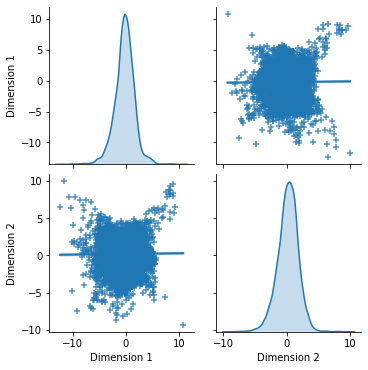

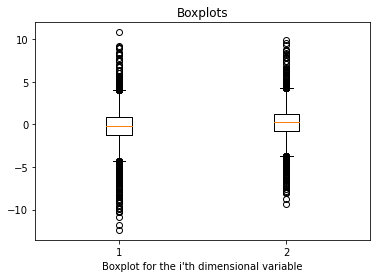

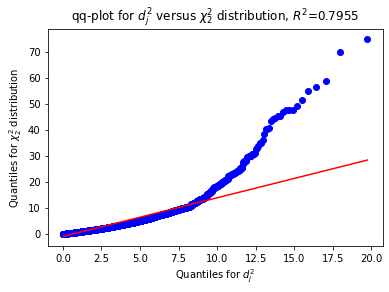

In [21]:
fcc.Metrics.stats.plot_model_check(residuals_xy_14dp)

In [22]:
correlation_coefficient_14dp, p_value_14dp = fcc.Metrics.stats.correlation_test(residuals_xy_14dp[:,0], residuals_xy_14dp[:,1], True)

In [23]:
table = PrettyTable()
table.field_names = ["Correlation Test (Spearman)", "Correlation Coefficient","p-value"]
table.add_row(["Residuals:", f"{correlation_coefficient_14dp:0.5f}",f"{p_value_14dp:0.5f}"])
print(table)

+-----------------------------+-------------------------+---------+
| Correlation Test (Spearman) | Correlation Coefficient | p-value |
+-----------------------------+-------------------------+---------+
|          Residuals:         |         -0.00591        | 0.49308 |
+-----------------------------+-------------------------+---------+


# TODO skriv hvad vi kan se

## Next we can look for any sytamatic error when reprojectiong the object point to the image plane

##### This can be done by makeing a voronoi diagram over the angles between the featur points and the correspointing reprojected points

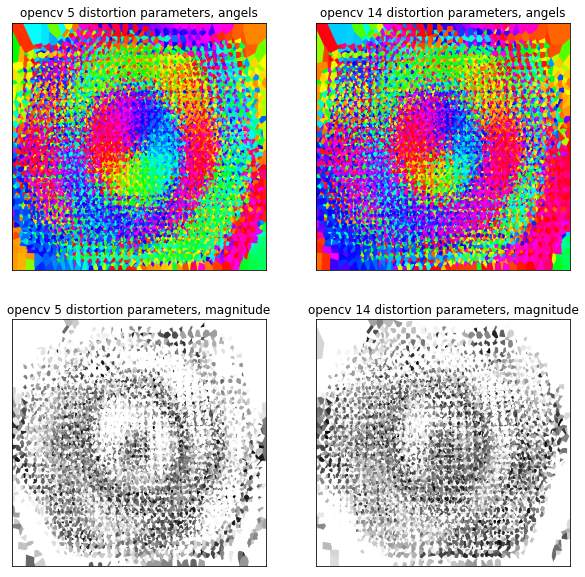

In [24]:
display(HTML("""<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/voronoi_example_colorbar.svg" width=300>"""))

img_points_all_5dp, diff_all_5dp, angels_all_5dp, mag_all_5dp = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(charucoCorners_all_5dp, obj_points_all_5dp, rvecs_5dp, tvecs_5dp, cameraMatrix_5dp, distCoeffs_5dp)
img_points_all_14dp, diff_all_14dp, angels_all_14dp, mag_all_14dp = fcc.Metrics.voronoi.projectPoints_and_cal_angles_and_mag(charucoCorners_all_14dp, obj_points_all_14dp, rvecs_14dp, tvecs_14dp, cameraMatrix_14dp, distCoeffs_14dp)

def remove_ticks():
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(10,10))

ax = plt.subplot(221)
plt.title("opencv 5 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, angels_all_5dp, ax=ax)
remove_ticks()

ax = plt.subplot(222)
plt.title("opencv 14 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, angels_all_14dp, ax=ax)
remove_ticks()

ax = plt.subplot(223)
plt.title("opencv 5 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, mag_all_5dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(224)
plt.title("opencv 14 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, mag_all_14dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

plt.show()

##### In the voronoi plots for both 5 and 14 distortion parameters pattens are clerly precent

## Last we can print the RMS reprojection error for the calibrations

In [25]:
table = PrettyTable()
table.field_names = ["Reprojection error", "opencv (4 + 5 parameters)", "opencv (4 + 14 parameters)"]
table.add_row(["RMS:", f"{calibrate_retval_5dp:0.5f}", f"{calibrate_retval_14dp:0.5f}"])
print(table)

+--------------------+---------------------------+----------------------------+
| Reprojection error | opencv (3 + 5 parameters) | opencv (3 + 14 parameters) |
+--------------------+---------------------------+----------------------------+
|        RMS:        |          2.61024          |          2.48643           |
+--------------------+---------------------------+----------------------------+


# Central Model - Generic Calibration

# TODO: Dem i fed

##### Generic Calibration contain several components to accommodate the more dense model. Instead of just having an equation with a couple of parameters we can apply to the image we have much more dense information about many of the involved pixels. So get ready. 

##### The fundamental idea In generic calibration is to associate each pixel with a direction from which it receives light. To represent these directions a set of vectors interpolated with a b-spline is used and to map the directions to the camera a bundle adjustment is performed on the vectors with regards to the calibration images. 

### Model representation. 
##### Each pixel needs a direction and directions are given as vectors in three dimensions, but in order to limit the size of the model not every pixel is assigned a full vector. Instead  a grid is constructed, whose intersections marks evenly spaced pixels over the image. These evenly spaced pixels are all given a vector, and a 2-dimensional b-spline interpolation is mapped to these vectors <strong>(We really need a picture of this)</strong>. The b-spline lets us calculate a direction vector for all the pixel between grid intersection. 
##### In summary our camera model is a set of vectors, and a b-spline that can interpolate between them. 

### Model Construction 

##### To construct the model the first thing that is needed is an initial guess of the model that can be used for bundle-adjustment. As usual optimization the better the initial guess the better results and the lower chance we find a non-optimal solution. Therefore as an initial guess we use the parametric calibration results. By backward projection pixel positions in the grid we can find vectors directions. The issue is now to map a b-spline to these vectors. b-splines are constructed from control points but these control points are not the same as our grid vectors. The grid vectors need to be on the spline so to find the control points an optimization is performed, that adjust the controlpoints until they return vectors that are close to the one from the backprojection. 

##### Now that we have an initial guess for the model we can start the bundle adjustment to optimize it. This bundle adjustment attempts to minimize the reprojection error, which is the difference between a projected image position based on the model and the actual position measured in the image. The projected image position is calculated from the known 3D position of the charuco boards using the camera model and b-spline. From the resulting reprojection error a correction step is calculated with TRS a trust region reflective algorithm and the process is repeated until the reprojection error is minimized. 


## Bundel adjustmen

##### Normally bundle adjustment is used to minimize the reprojection error, which would be the average error of all 3D points projected onto the cameras 2D image plane. However as meantioned in the introduction, this is not a simple task with the generic model and causes an optimization problem. Finding the optimal 2D point for each 3D point using the generic model will take a lot of time, so instead of projecting the 3D point to 2D, the 2D point is projected to 3D. The residuals are then calculated as the length of the vector between the points. This does however result in the generic model being optimized to best fit these residuals and not the pixel error in 2D.

In [26]:
from flexiblecc.CentralModel import BundleAdjustment

##### As our camera model can do backward projection directly but requires an optimization to do forward projection, the residuals used for doing the bundle adjustment is different from the usual difference in pixels. Instead, rays going towards the 3D features on the checkerboards are calculated using the checkerboard extrinsics and then compared to the rays from the models from the pixel coordinates of the same features. This means that the residuals will be measured in units of ‘checkerboard markers’; i.e. Euclidian distance in some real-world unit (m, cm).

<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_2.svg" > <img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_1.svg" >

### Prefit

##### As the bundle adjustment requires a good initial guess of the camera model, the model has to be initialized. This is done by calculating the backward projection from a parametric camera model and then optimizing the control points of the generic model to fit the parametric model. 

##### Ilustrion of the fittet BSpline with the control points (green points) to go thruge the via points (white points) from the parametric model.

In [27]:
Video("https://github.com/SimonLBSoerensen/Flexible-Camera-Calibration/blob/master/static/bspline.mp4?raw=true", width=800, html_attributes="loop autoplay")

In [28]:
ba = BundleAdjustment(obj_points_all_14dp, rvecs_14dp, tvecs_14dp, charucoCorners_all_14dp, cameraMatrix_14dp, 
                      distCoeffs_14dp, image_shape, cm_stepsize=252, cm_order=2)

Generating sparsity matrix
Starting least squares fitting of CentralModel.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.7389e-02                                    2.91e-02    
       1              2         6.0171e-18      5.74e-02       3.58e-01       4.86e-10    
`gtol` termination condition is satisfied.
Function evaluations 2, initial cost 5.7389e-02, final cost 6.0171e-18, first-order optimality 4.86e-10.


##### To increase the speed of the bundle adjustment, we use the sparsity matrix to describe the relationship between the parameters and residuals. The sparsity matrix is shown in the plot below. The blue markers indicat which residuals are affected, when changing specific parameters. 
##### The plot only gives a indication of how it looks.

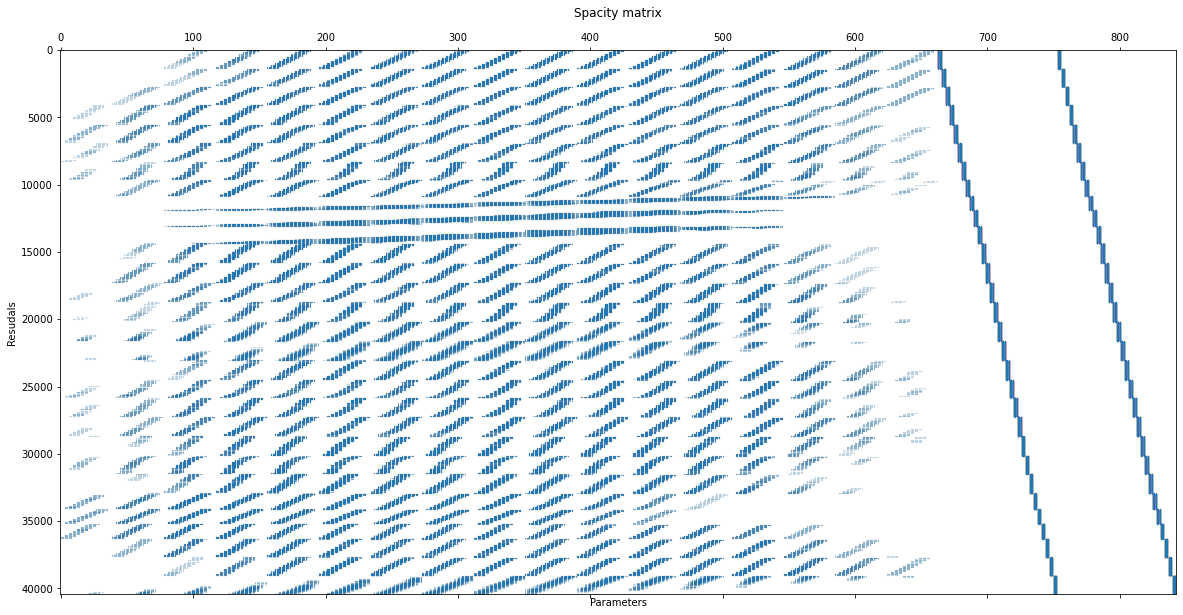

In [54]:
fig, ax = plt.subplots(figsize=[20,10])
plt.title("Spacity matrix")

ax.spy(ba.A, aspect="auto", markersize=0.02)
plt.xlabel("Parameters")
plt.ylabel("Resudals")

plt.show()

##### The least_squares() method performs the optimization using the parameters specified, when creating the BundleAdjustment object. It returns the control points for the b-spline, a scipy.optimize.OptimizeResult, the rotation vectors and the translation vector.

In [30]:
cm, res, rvecs_new, tvecs_new = ba.least_squares()

Performing least squares optimization on the control points and position of the chessboards
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3399e-03                                    7.19e-01    
       1              2         2.8172e-03      1.52e-03       1.14e-02       1.61e-01    
       2              3         2.6305e-03      1.87e-04       7.20e-03       7.53e-02    
       3              4         2.5482e-03      8.23e-05       6.44e-03       4.99e-02    
       4              6         2.5195e-03      2.86e-05       1.23e-02       3.90e-02    
       5              7         2.4869e-03      3.26e-05       3.47e-03       3.28e-02    
       6              8         2.4650e-03      2.19e-05       3.16e-03       3.11e-02    
       7              9         2.4492e-03      1.58e-05       3.26e-03       4.53e-02    
       8             10         2.4359e-03      1.33e-05       3.99e-03       4.55e-02   

New we can save the model for leater use

In [31]:
fcc.CentralModel.cm_save(cm, "cm.npz")

# Results
##### The two methods can be compared in a single number the residual, which is the RMS of the error, however this number says nothing about the distribution of the error over the image. To visualize this a voronoi diagram is constructed of the direction and one of the magnitude. From the voronoi diagram it can be seen that the parametric camera model contains artifacts or patterns  in the error, and this is where a potential bias in the calibration comes from. The generic model has a more even distribution of the error and this combined with the lower RMS error is why it is a superior method, although also slightly slower. 

##### Below is a flowchart of the calculation of the 2D residuals used to compare the generic to the parametric model. scipy.optimize.minimize is used with Powell's method to find the 2D points resulting in the given 3D rays, these 2D points are then compared to the known 2D points in the image to find the residuals.

<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/Residual_Calculation_3.svg" > <img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/dd3e040c02a82ae2f4a69b7d89f520f70b987b15/static/Residual_Calculation_1.svg">

##### Now we can reproject the object points into the image plane to calculate the residuals

In [33]:
cm_rms, residuals_2D, estimated_points_2D, correct_points_2D = ba.calc_residuals_2D(res.x, return_points_2D=True, verbose=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [17:39<00:00, 35.31s/image]


### Model check for the residuals

##### One of the supposed advantages of using the generic model is the reduction of bias in the distortion. To help verify if this truly happens a test for normality can be performed on the residuals. 

TODO: Skriv hvad der er på billederne ?

In [34]:
residuals_xy = np.concatenate(estimated_points_2D - correct_points_2D).reshape(-1,2)

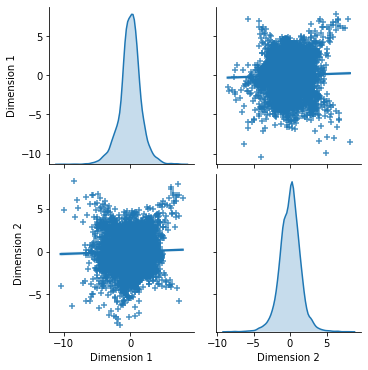

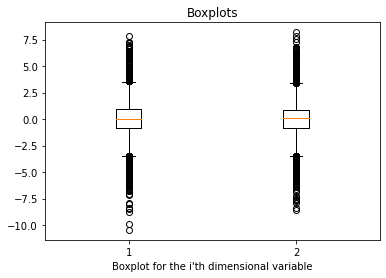

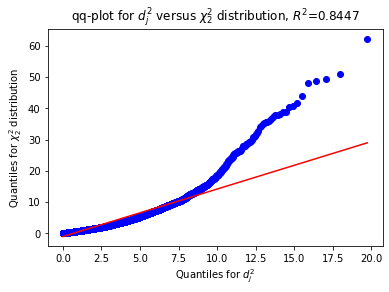

In [35]:
fcc.Metrics.stats.plot_model_check(residuals_xy)

In [36]:
correlation_coefficient, p_value = fcc.Metrics.stats.correlation_test(residuals_xy[:,0], residuals_xy[:,1], True)

In [37]:
table = PrettyTable()
table.field_names = ["Correlation Test (Spearman)", "Correlation Coefficient","p-value"]
table.add_row(["Residuals:", f"{correlation_coefficient:0.5f}",f"{p_value:0.5f}"])
print(table)

+-----------------------------+-------------------------+---------+
| Correlation Test (Spearman) | Correlation Coefficient | p-value |
+-----------------------------+-------------------------+---------+
|          Residuals:         |         0.00207         | 0.80982 |
+-----------------------------+-------------------------+---------+


### Voronoi

##### Another way to test bias is to calculate which way in the image the residual is pointing and presenting it in a voronoi diagram. 
##### When comparing the generic model with the parametric model it is clear that there is a pattern in the error of the parametric model that is not present in the generic model. The pattern resembles concentric circles, possible because it is some artifact of radial distortion or the correction thereof. The pattern is clearer in the 5 distortion parameter model than in the 14 distortion parameter model. 
##### The pattern is also present in the residual magnitude plot. The error for the parametric problem comes in concentric circles and the highest error is at the edge of the image, where in the generic model the error is more evenly distributed.


In [38]:
image_points = np.concatenate(correct_points_2D)
project_points = np.concatenate(estimated_points_2D)
imp, diff, angels, mag = fcc.Metrics.voronoi.cal_angles_and_mag(image_points, project_points)

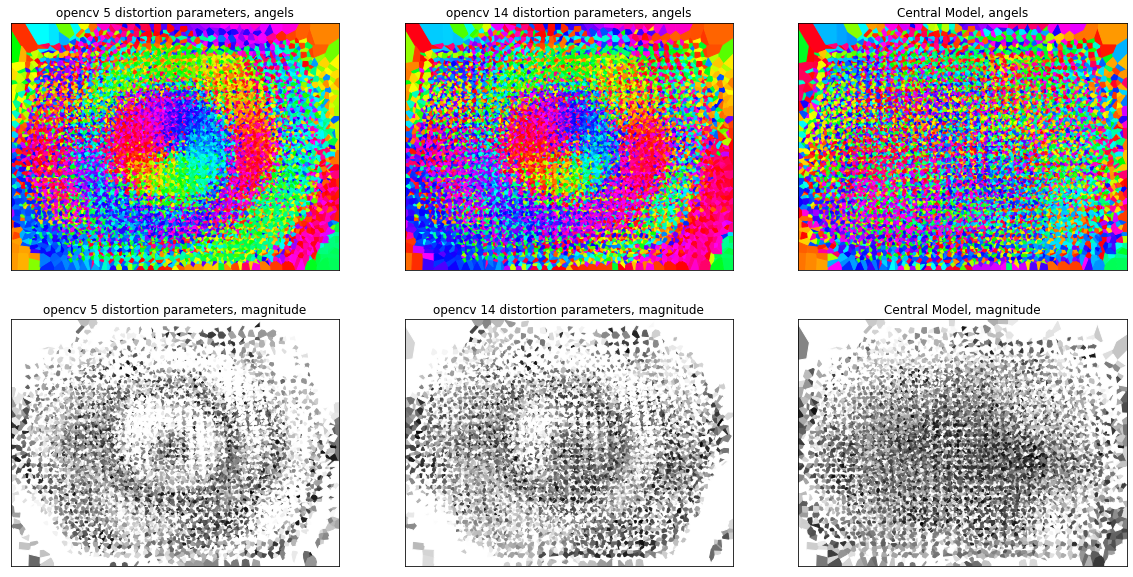

In [39]:
display(HTML("""<img src="https://raw.githubusercontent.com/SimonLBSoerensen/Flexible-Camera-Calibration/master/static/voronoi_example_colorbar.svg" width=300>"""))

plt.figure(figsize=(20,10))

ax = plt.subplot(231)
plt.title("opencv 5 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, angels_all_5dp, ax=ax)
remove_ticks()

ax = plt.subplot(232)
plt.title("opencv 14 distortion parameters, angels")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, angels_all_14dp, ax=ax)
remove_ticks()

ax = plt.subplot(233)
plt.title("Central Model, angels")
fcc.Metrics.voronoi.plot_voronoi(imp, angels, ax=ax)
remove_ticks()

ax = plt.subplot(234)
plt.title("opencv 5 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_5dp, mag_all_5dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(235)
plt.title("opencv 14 distortion parameters, magnitude")
fcc.Metrics.voronoi.plot_voronoi(img_points_all_14dp, mag_all_14dp, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

ax = plt.subplot(236)
plt.title("Central Model, magnitude")
fcc.Metrics.voronoi.plot_voronoi(imp, mag, ax=ax, angles=False, magnitude_treshold=2, magnitude_color_mode="gray")
remove_ticks()

plt.show()

# TODO: (M)
- Skriv noget her

In [40]:
table = PrettyTable()
table.field_names = ["Reprojection error", "opencv (4 + 5 parameters)", "opencv (4 + 14 parameters)", f"Central Model ({np.product(cm.a.shape)} parameters)"]
table.add_row(["RMS:", f"{calibrate_retval_5dp:0.5f}", f"{calibrate_retval_14dp:0.5f}", f"{cm_rms:0.5f}"])
print(table)

+--------------------+---------------------------+----------------------------+--------------------------------+
| Reprojection error | opencv (4 + 5 parameters) | opencv (4 + 14 parameters) | Central Model (663 parameters) |
+--------------------+---------------------------+----------------------------+--------------------------------+
|        RMS:        |          2.61024          |          2.48643           |            2.15168             |
+--------------------+---------------------------+----------------------------+--------------------------------+
